In [1]:
!pip install pysindy

In [2]:
import numba
import numpy as np
from tqdm.notebook import tqdm
from ipywidgets import interact
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA

import torch
from torch import nn
from torch.utils.data import DataLoader
from google.colab import files
import pysindy as ps
sns.set(font_scale=1.4)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Check GPU

In [3]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is not available.  Training on CPU ...


In [4]:
!nvidia-smi
torch.cuda.is_available()

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



False

Next function implements one time step of explicit finite-difference scheme for Laplace equaion:
$$
u_t = u_{xx} + u_{yy}
$$

In [0]:
def get_next_step(u, h, tau):
    """
    u --- (N + 1, N + 1) array
    h --- space step
    tau --- time step
    """

    N = len(u) - 1
    x_index = np.repeat(np.arange(1, N)[:, np.newaxis], 
                                N-1, axis=1)
    y_index = np.repeat(np.arange(1, N)[np.newaxis, :], 
                            N-1, axis=0)
    
    vicinity = u[x_index + 1, y_index] + u[x_index, y_index + 1] + \
               u[x_index - 1, y_index] + u[x_index, y_index -1]
    
    right_side = (vicinity - 4 * u[x_index, y_index]) * tau / h ** 2
    u[x_index, y_index] += right_side

    residual = np.linalg.norm(right_side[:]/tau) * h**0.5

    return u, residual

def compute_residual(u, h, tau):
    """
    u --- (N + 1, N + 1) array
    h --- space step
    tau --- time step
    """

    N = len(u) - 1
    x_index = np.repeat(np.arange(1, N)[:, np.newaxis], 
                                N-1, axis=1)
    y_index = np.repeat(np.arange(1, N)[np.newaxis, :], 
                            N-1, axis=0)
    
    vicinity = u[x_index + 1, y_index] + u[x_index, y_index + 1] + \
               u[x_index - 1, y_index] + u[x_index, y_index -1]
    
    right_side = (vicinity - 4 * u[x_index, y_index]) * tau / h ** 2

    residual = np.linalg.norm(right_side[:]/tau) * h**0.5

    return  residual

Задаём размер сетки и начальное и граничное условия

Compute solution for prescribed number of time steps. Save solution each ```print_every``` time steps.

In [6]:
n_of_time_steps = 10 * 10 ** 3
N = 100
history = np.zeros((n_of_time_steps, N + 1, N + 1))
residual = np.zeros(n_of_time_steps + 1)
print_every = 1 # 


X = np.linspace(-1, 1, N + 1)
Y = np.linspace(-1, 1, N + 1)



X, Y = np.meshgrid(X, Y)
u_in = np.sin(X + Y ** 2) # Boundary condition
u_in[1:N, 1:N] = 0 # Initial condition 

u = u_in

h = 2 / N # space step
tau = 0.1 * h**2 # time step
for i in tqdm(range(n_of_time_steps)):
    if (i % print_every == 0):
        history[i // print_every] = u
    u, residual[i] = get_next_step(u, h, tau)
residual[-1] = compute_residual(u, h, tau)

In [0]:
print_every = 1

Plot residual norm

Text(0, 0.5, '$\\Vert R \\Vert$')

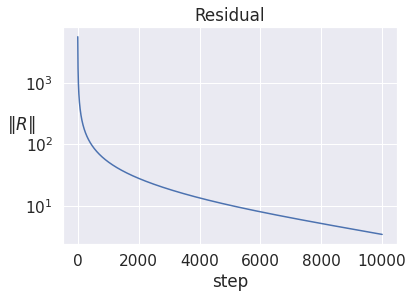

In [8]:
plt.semilogy(residual)
plt.title('Residual')
plt.xlabel('step')
plt.ylabel('$\Vert R \Vert$', rotation = 0)

Save solution on the drive



In [0]:
np.save('./history.npy',
        history
        )

In [0]:
history = np.load(
    './history.npy'
    )

Visualize solution.


In [0]:
def plot(index):
    plt.figure(figsize=(8, 8))
    sns.heatmap(history[index])
    plt.show()

In [12]:
interact(plot, index=(0, n_of_time_steps - 1))

interactive(children=(IntSlider(value=4999, description='index', max=9999), Output()), _dom_classes=('widget-i…

<function __main__.plot>

In [0]:
# Move from solutions to delta U

# history = history[1:] - history[:-1]

Construct encoder-decoder using small part of history

In [0]:
start = 1000 # start index in history
batch = 500 # batch size
low_dim = 3 # number of dimensions in low-dimensional space

Construct autoencoder based on Principal Component Analysis (PCA).

In [0]:
class PCA_autoenc:
    def __init__(self, low_dim):
        self.pca = PCA(n_components = low_dim)
    
    def fit(self, x):
      '''x = (n_of_snapshots, vector_size)
      '''
      self.pca.fit_transform(x)
    
    def encode(self, x_high_dim):
        return self.pca.transform(x_high_dim)

    def decode(self, x_low_dim):
        return self.pca.inverse_transform(x_low_dim)

In [0]:
pca_autoenc = PCA_autoenc(low_dim = 3)

sub_hist = history[start:start + batch].reshape(-1, (N + 1) * (N + 1))

mean = 0.# np.mean(sub_hist)
std = 1.#np.std(sub_hist)

sub_hist = (sub_hist - mean) / std 
pca_autoenc.fit(sub_hist)

In [0]:
history_low_dim =pca_autoenc.encode(history.reshape(-1, (N + 1) * (N + 1)))

Note: components of low-dimensional vector decrease exponentially with number (this is general result for SVD of projection of smooth function on a mesh). 

But for future solutions all components get large. We have to account for that when training predictive model.

Let's check compression accuracy on 'test set' - future time steps

In [18]:
future_batches = 3
X_ = history[start + batch : start + batch + future_batches * batch]
X = X_.reshape(future_batches * batch, -1)

X = (X - mean) / std
print('X.shape = ', X.shape)
x = pca_autoenc.encode(X)
print('x.shape = ', x.shape)

X_decode = pca_autoenc.decode(x)
error = np.linalg.norm(X[:] - X_decode[:]) / (batch * (N+1) **2)
print('error in fro-norm = {0:5.2e}'.format(error))

X.shape =  (1500, 10201)
x.shape =  (1500, 3)
error in fro-norm = 1.22e-06


Plot graphs for different components of low-dimentional vector. It can be seen that dependence on time is very smooth. Therefore we hope that we can effectively predict future states. 

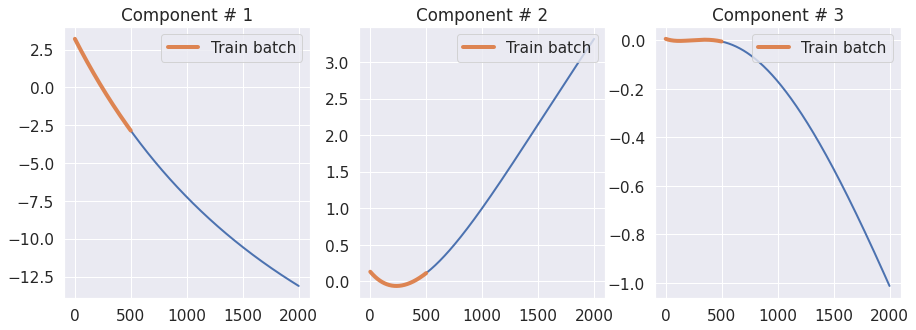

In [68]:
fig, axes = plt.subplots(1,3, figsize = (15,5))
for i in range(low_dim): 
    axes[i].plot(history_low_dim[start : start + (future_batches + 1) * batch, i], lw = 2)
    axes[i].plot(history_low_dim[start : start + 1 * batch, i], lw = 4, label = 'Train batch')
    # plt.plot(np.arange(batch, (future_batches + 1) * batch), x[:, i], label = 'test set')
    axes[i].legend(loc = 'upper right')
    axes[i].set_title('Component # ' + str(i+1))
fname = 'PCA_on_iter.png'
plt.savefig(fname, format = 'png', dpi = 600, bbox_inches = 'tight')
files.download(fname)

In [0]:
x_train = pca_autoenc.encode(
    history[start : start + batch].reshape(-1, (N + 1) * (N + 1))
    )


Try to use [https://github.com/dynamicslab/pysindy] library

In [0]:
class Sindy_predictor:
    def __init__(self):
        self.model = ps.SINDy()

    def fit(self, snapshots, dt):
      self.model.fit(snapshots, t = dt)
      self.dt = dt

    def predict(self, x0, t):
      # predict solution for times in array "t"
      x = self.model.simulate(x0, t)
      return x



In [51]:
sindy_predictor = Sindy_predictor()

# scales = np.std(x_train, axis = 0)
scales = 1
x_train_scaled = x_train / scales
print(scales)

# stlsq_optimizer = ps.STLSQ(threshold=1e-1, fit_intercept = True)
# # sr3_optimizer = ps.SR3(threshold=1e+0, nu=1)
# smoothedFD = ps.SmoothedFiniteDifference()
model = ps.SINDy()
dt = tau
sub_batch = batch//2
model.fit(x_train_scaled[-sub_batch:, :], t = dt)
sindy_predictor.fit(x_train_scaled[-sub_batch:, :], dt)
model.print()

1
x0' = -15662.877 1 + -1204.180 x0 + -249969.109 x1 + -66496.990 x2 + 5018.589 x0^2 + 2433.188 x0 x1 + 224.677 x0 x2 + 50.479 x1^2
x1' = 1.402 1 + -12.128 x0 + -0.764 x0^2 + -0.660 x0 x1
x2' = 0.816 1 + 0.107 x0 + -0.437 x0^2 + -1.340 x0 x1


Plot results on training set

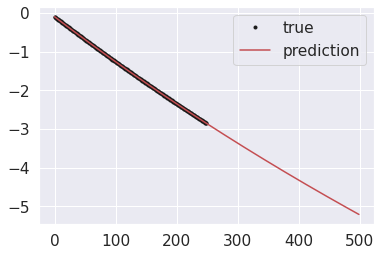

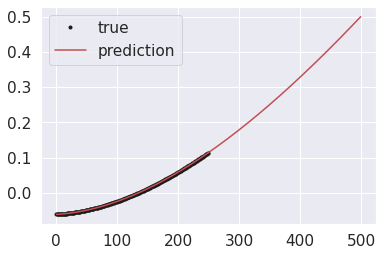

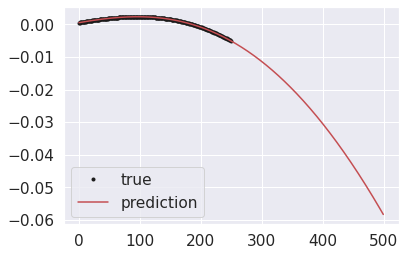

In [52]:
x0_train_scaled = x_train[-sub_batch, :] / scales # Initial condition for integration
t_train = np.arange(2*sub_batch ) * dt

# integrator_args = {'rtol' : 1e-16, 'hmax' : 1e-3* dt, 'h0' : 1e-3 * dt}
x_test_sim_scaled = sindy_predictor.predict(x0_train_scaled,
                            t_train)
x_test_sim = x_test_sim_scaled * scales

for i in range(low_dim):
    plt.plot(x_train[-sub_batch:, i],'k.', label = 'true')
    plt.plot(x_test_sim[:, i], 'r-',label = 'prediction')
    # plt.plot(np.arange(sub_batch, sub_batch + batch), x[:batch, i], 'g.')
    plt.legend()
    plt.show()

Plot results for future points

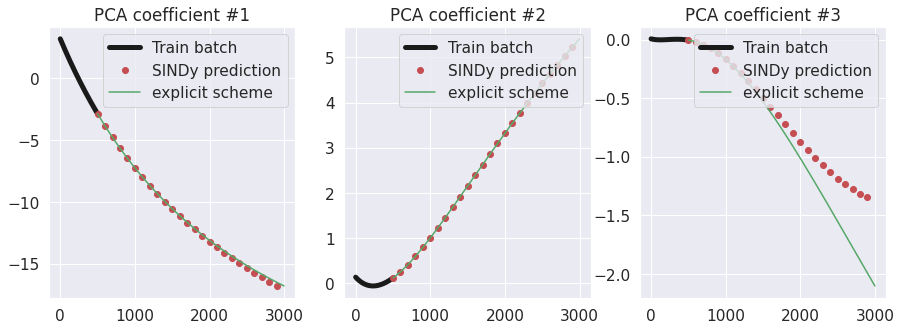

In [75]:
x0_train_scaled = x_train[-1, :] / scales # Initial condition for integration
t_train = np.arange((future_batches + 2) * batch) * dt

# integrator_args = {'rtol' : 1e-16, 'hmax' : dt, 'h0' : dt}
x_test_sim_scaled = sindy_predictor.predict(
                            x0_train_scaled,
                            t_train)

x_test_sim = x_test_sim_scaled * scales

fig, axes = plt.subplots(1,3, figsize = (15,5))
for i in range(low_dim):
    axes[i].plot(x_train[-batch:, i], 'k-', lw = 5, label = 'Train batch')
    axes[i].plot(np.arange(batch, batch + len(x_test_sim), 100), x_test_sim[::100, i], 'ro',label = 'SINDy prediction')
    axes[i].plot( np.arange(batch, batch + len(x_test_sim)),
             history_low_dim[start + batch : start + (future_batches + 3) * batch, i], 
             'g-', label = 'explicit scheme'
             )
    axes[i].set_title('PCA coefficient #' + str(i+1))
    axes[i].legend(loc = 'upper right')

fname = 'SINDY_components.png'
plt.savefig(fname, format = 'png', dpi = 600, bbox_inches = 'tight')
files.download(fname)

Посмотрим, как меняется невязкая для предсказанных значений. 

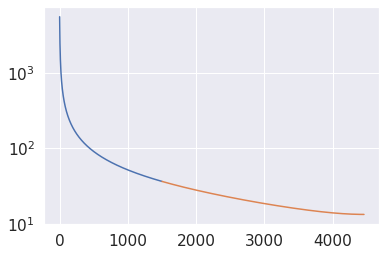

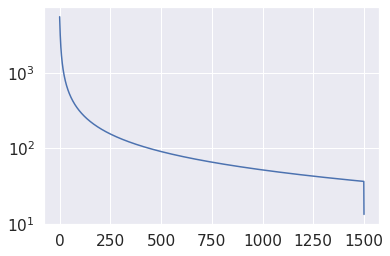

In [25]:
# Сначала декодируем
U_pred= pca_autoenc.decode(x_test_sim)
U_pred = U_pred.reshape(-1, N + 1, N + 1)  
#
residual_sindy = []

for k in range(U_pred.shape[0] - sub_batch):
    residual_sindy.append(
        compute_residual(U_pred[k + sub_batch, :, :],  h, tau)
    )
residual_sindy = np.array(residual_sindy)
i_min = np.argmin(residual_sindy)
plt.semilogy(residual[:start + batch])

plt.semilogy(np.arange(start + batch, start + batch + i_min),
             residual_sindy[: i_min])
plt.show()
plt.semilogy(np.concatenate(
    (residual[: start + batch],
    np.array([residual_sindy[i_min]]))))

### Final experiments
General function for testing different approaches. It gets autoencoder, predictor, and set of numerical parameters, and return residuals for each iteration. Then we compare it with baseline explicit scheme.

In [0]:
import copy

def my_solver(u_in, h, tau, autoenc, predictor, parameters):
    '''my_solver function

    Arguments:
    u_in (int) -- initial condition

    Returns:

    '''
    
    iter_counter = 0
    residuals = []
    nx = u_in.shape[0]
    ny = u_in.shape[1]
    u = copy.deepcopy(u_in)
    # Skip first iterations
    residuals.append(compute_residual(u, h, tau))
    for i in range(parameters.skip_first):
        u, _ = get_next_step(u, h, tau)
        residual = compute_residual(u, h, tau)
        residuals.append(residual)
        iter_counter = iter_counter + 1

    # Start main cycle
    history = np.zeros((parameters.batch_size,
                        nx,
                        ny))
    sparse_history = np.zeros((parameters.batch_size, nx * ny))
    number_of_pred = 0
    while(iter_counter < parameters.iter_num):
        # Compute batch solutions
        for it in range(parameters.batch_size):
            u, _ = get_next_step(u, h, tau)
            history[it, :, :] = u
            residual = compute_residual(u, h, tau)
            residuals.append(residual)
            iter_counter = iter_counter + 1

        number_of_pred = number_of_pred + 1
        print('Start prediction # {0:d}'.format(number_of_pred))
        sparse_history[:, :] = history.reshape(-1, nx * ny)

        # Normalize snapshots
        # mean = np.mean(sparse_history)
        # std = np.std(sparse_history)
        # sparse_history = (sparse_history - mean) / std


        # Train autoencoder
        # pca_autoenc.fit(history[start:start + batch].reshape(-1, (N + 1) * (N + 1)))
        autoenc.fit(
            sparse_history
        )
        # encode solutions
        sparse_history_low_dim = autoenc.encode(sparse_history)

        # Normalize sparse_history_low_dim
        # mean = np.mean(sparse_history_low_dim[:, 0])
        std = np.std(sparse_history_low_dim[:, 0])
        sparse_history_low_dim = sparse_history_low_dim / std


        # Train predictor
        # sindy_predictor.fit(x_train_scaled[-sub_batch:, :], dt)
        predictor.fit(
            sparse_history_low_dim[-parameters.pred_batch_size::parameters.pred_train_step, :],
            dt = tau * parameters.pred_train_step
        )
        # Predict future solution 
        x0 = sparse_history_low_dim[-parameters.pred_batch_size, :]
        pred_residuals = [residuals[-parameters.pred_batch_size]]

        pred_step_num = 0
        while(True):
            pred_step_num = pred_step_num + 1
            x_pred = predictor.predict(x0, np.array([0., tau]))

            # Denormalize 
            # Decode
            x_pred_high_dim = autoenc.decode(x_pred[-1] * std)
            
            # Denormalize
            # x_pred_high_dim  = x_pred_high_dim * std + mean

            x_pred_high_dim = x_pred_high_dim.reshape(-1, nx, ny)
            res = compute_residual(x_pred_high_dim[0],  h, tau)
            if (res < 1e-4):
                print('Residual is very low, stop')
                break
            if (res < pred_residuals[-1]):
                pred_residuals.append(res)
                x0 = x_pred[-1, :]
            else:
                break
        print('pred_step_num = {0:d}'.format(pred_step_num))
        u = autoenc.decode(x0 * std).reshape(nx, ny)

    return u, residuals 

In [0]:
class Parameters:
  def __init__(self):
      self.skip_first = 1500
      self.save_every = 1
      # number of time steps before prediction
      self.batch_size = 500

      # number of last shapshots
      # used to train predictor
      self.pred_batch_size = 400

      # 
      self.pred_train_step = 1
      
      # number of steps for predictor
      # 2 - 3 batch_size
      self.pred_step_num = 1000   
      # Max number of iterations
      self.iter_num = 10**4

In [97]:
p = Parameters()
N = 100

X = np.linspace(-1, 1, N + 1)
Y = np.linspace(-1, 1, N + 1)



X, Y = np.meshgrid(X, Y)
u_in = np.sin(X + Y ** 2) # Boundary condition
u_in[1:N, 1:N] = 0 # Initial condition 

h = 2 / N # space step
tau = 0.1 * h**2 # time step

pca_autoenc = PCA_autoenc(low_dim = 3)
sindy_predictor = Sindy_predictor()
stlsq_optimizer = ps.STLSQ(
    threshold= 1e-1, 
    alpha=0.05
    )

fourier_library = ps.FourierLibrary(n_frequencies=3)
pol_library = ps.PolynomialLibrary(degree = 2)
combined_library = pol_library

sindy_predictor.model = ps.SINDy(
    feature_library= combined_library,
    optimizer = stlsq_optimizer
    )

u, residuals_accelerated = my_solver(u_in, h, tau, pca_autoenc, sindy_predictor, p)

Start prediction # 1
pred_step_num = 2916
Start prediction # 2
pred_step_num = 2853
Start prediction # 3
pred_step_num = 2264
Start prediction # 4
pred_step_num = 4792
Start prediction # 5
pred_step_num = 11981
Start prediction # 6
pred_step_num = 2068
Start prediction # 7
pred_step_num = 1577
Start prediction # 8
pred_step_num = 3340
Start prediction # 9
pred_step_num = 835
Start prediction # 10
pred_step_num = 630
Start prediction # 11
pred_step_num = 1484
Start prediction # 12
pred_step_num = 834
Start prediction # 13
pred_step_num = 801
Start prediction # 14
pred_step_num = 154
Start prediction # 15


/usr/local/lib/python3.6/dist-packages/pysindy/optimizers/stlsq.py:156: UserWarning: Sparsity parameter is too big (0.1) and eliminated all coefficients
  "coefficients".format(self.threshold)


pred_step_num = 1169
Start prediction # 16
pred_step_num = 703
Start prediction # 17
pred_step_num = 986


In [94]:
print('Minimal residual = {0:5.2e}'.format(residuals_accelerated[-1]))

Minimal residual = 2.04e-01


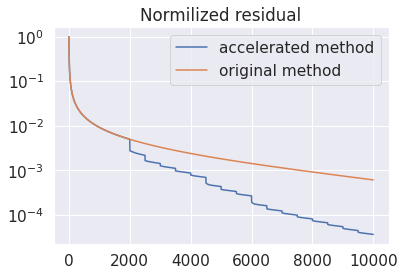

In [95]:
plt.semilogy(residuals_accelerated/residuals_accelerated[0], label = 'accelerated method')
plt.semilogy(residual/residual[0], label = 'original method')
plt.legend()
plt.title('Normilized residual')
fname = 'compare_residuals.png'
plt.savefig(fname, format = 'png', dpi = 600, bbox_inches = 'tight')
# files.download(fname)

In [0]:
import torch.nn.functional as F

# define the NN architecture
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        ## encoder layers ##
        # conv layer (depth from 1 --> 16), 3x3 kernels
        self.conv1 = nn.Conv2d(1, 8, 3, stride = 2,  padding=0)  
        # conv layer (depth from 16 --> 4), 3x3 kernels
        self.conv2 = nn.Conv2d(8, 2, 3, stride = 2, padding=0)
        # pooling layer to reduce x-y dims by two; kernel and stride of 2
        self.pool = nn.MaxPool2d(2, 2)
        
        ## decoder layers ##
        ## a kernel of 2 and a stride of 2 will increase the spatial dims by 2
        self.t_conv1 = nn.ConvTranspose2d(2, 4, 4, stride=1)
        self.t_conv2 = nn.ConvTranspose2d(4, 4, 4, stride=2, padding = 0)
        self.t_conv3 = nn.ConvTranspose2d(4, 1, 4, stride=2, padding = 0)
        self.t_conv4 = nn.ConvTranspose2d(1, 1, 4, stride=2, padding = 0)

    def forward(self, x):
        ## encode ##
        # add hidden layers with relu activation function
        # and maxpooling after
        x = torch.sigmoid(self.conv1(x))
        x = self.pool(x)
        # add second hidden layer
        x = torch.sigmoid(self.conv2(x))
        x = self.pool(x)  # compressed representation
        
        ## decode ##
        # add transpose conv layers, with relu activation function
        x = torch.sigmoid(self.t_conv1(x))
        # output layer (with sigmoid for scaling from 0 to 1)
        x = torch.sigmoid(self.t_conv2(x))

        x = torch.sigmoid(self.t_conv3(x))
        x = self.t_conv4(x)
        return x
    
    def encode(self, x):
        ## encode ##
        # add hidden layers with relu activation function
        # and maxpooling after
        x = torch.sigmoid(self.conv1(x))
        x = self.pool(x)
        # add second hidden layer
        x = torch.sigmoid(self.conv2(x))
        x = self.pool(x)  # compressed representation
        return x

    def decode(self, x):
        return 

# initialize the NN
auto_enc = ConvAutoencoder().cuda()
# print(model)
from torchsummary import summary
summary(auto_enc, (1, 101,101))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 50, 50]              80
         MaxPool2d-2            [-1, 8, 25, 25]               0
            Conv2d-3            [-1, 2, 12, 12]             146
         MaxPool2d-4              [-1, 2, 6, 6]               0
   ConvTranspose2d-5              [-1, 4, 9, 9]             132
   ConvTranspose2d-6            [-1, 4, 20, 20]             260
   ConvTranspose2d-7            [-1, 1, 42, 42]              65
   ConvTranspose2d-8            [-1, 1, 86, 86]              17
Total params: 700
Trainable params: 700
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.04
Forward/backward pass size (MB): 0.28
Params size (MB): 0.00
Estimated Total Size (MB): 0.32
----------------------------------------------------------------


In [0]:
hidden_dim = 100

class SimpleModel(nn.Module):

    def __init__(self):
        super().__init__()

        self.rnn = nn.LSTM(low_dim, hidden_dim)
        self.decoder = nn.Linear(hidden_dim, low_dim)

    def forward(self, seq, hidden=None):
        output, last_hidden = self.rnn(seq, hidden)
        return self.decoder(output), last_hidden


In [0]:
model = SimpleModel().double().cuda()
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
train = torch.from_numpy(history_low_dim).cuda()

# Разбиваем последовательность на пары вход-выход
def create_inout_sequences(input_data, in_size):
    '''
    input_data[i] - i-й элемент последовательности
    in_size - длина входной последовательности
    по in_size элементам мы будем предсказывать 
    следующий элемент
    '''
    inout_seq = []
    seq_len = len(input_data)
    for i in range(seq_len - in_size):
        train_seq = input_data[i : i + in_size]
        train_label = input_data[i + in_size : i + in_size + 1]
        inout_seq.append((train_seq, train_label))
    return inout_seq
	
model.train()
train_loss = []
num_epochs = 10

for epoch in tqdm(range(num_epochs)):
    output, last_hidden = model(train[:-1].view(-1, 1, low_dim))
    loss = loss_func(output.view(-1, low_dim), train[1:, :])
    train_loss.append(loss.item())
    optimizer.zero_grad()

    loss.backward()

    optimizer.step()


    # model.eval()

    # output, _ = model(val[:-1].view(-1, 1, 10), last_hidden)

    # loss = loss_func(output.view(-1, 10), val[1:])
    # val_loss.append(loss.item())
	
in_size = 100

train_inout_seq = create_inout_sequences(train, in_size)

# model.train()
# train_loss = []
# num_epochs = 1000
# for epoch in tqdm(range(num_epochs)):
#     for seq, label in train_inout_seq:
#       # Зануляем hidden_state
#       hidden_state = (torch.zeros(1, 1, hidden_dim),
#                         torch.zeros(1, 1, hidden_dim))
#       # Вычисляем 
#       output, last_hidden = model(train[:-1].view(-1, 1, 10))
#       loss = loss_func(output.view(-1, 10), train[1:, :])
#       train_loss.append(loss.item())
#       optimizer.zero_grad()

#       loss.backward()

#       optimizer.step()


#     # model.eval()

#     # output, _ = model(val[:-1].view(-1, 1, 10), last_hidden)

#     # loss = loss_func(output.view(-1, 10), val[1:])
#     # val_loss.append(loss.item())


plt.semilogy(train_loss, label='train')
# plt.plot(val_loss, label='Val')
plt.title('Ошибка MSE')
plt.legend()
plt.show()


model.eval()

seq_len = 200

predicted = np.zeros((batch - seq_len, low_dim))

for i in range(batch - seq_len):
    output, last_hidden = model(train[i : i + seq_len].view(-1, 1, low_dim))
    
    predicted[i, :] = output[-1, :, :].cpu().detach().numpy()
output.shape

# Теперь экстраполируем 

i = 0 # number of component
plt.plot(history_low_dim[seq_len:, i], label = 'true' +  str(i+1) + '-component')
plt.plot(predicted[:, i], 'k.', label = 'LSTM prediction')

plt.legend()
plt.show()

model.eval()
import copy
seq_len = 100
sequence = torch.from_numpy(history_low_dim).cuda()
print(sequence.shape)
# output, last_hidden = model(sequence[-batch:].view(-1, 1, low_dim))
# TODO: как использовать hidden_state с предыдущих шагов?
for i in tqdm(range(batch)):
    # Предсказываем следующий элемент последовательности и hidden_state 
    output, last_hidden = model(sequence[-seq_len:].view(-1, 1, low_dim))
    # Добавляем новый элемент в конец
    sequence = torch.cat((sequence, output[-1]))
print(output.shape)


residual_lstm = []
sequence_numpy = sequence.data.cpu().numpy()

u = decode(sequence_numpy[:, :])
u = u.reshape((-1, N+1, N+1))

for i in tqdm(range(len(u))):
    res = compute_residual(u[i, :, :], h, tau)
    residual_lstm.append(res)
	
	
plt.plot(residual_lstm)
plt.show()
plt.plot(residual_lstm[batch:])


# val_results = output.view(-1, 10).cpu().detach().numpy()
# reshaped_results = np.zeros((5000, (N + 1) * (N + 1)))

# new_output = val[0].view(-1, 1, 10)
# new_hidden = last_hidden

# for i in range(5000):
#     new_output, new_hidden = model(new_output, new_hidden)
#     reshaped_results[i] = \
#         PCA_list[(1500 + i) // 500].inverse_transform(
#             new_output.cpu().detach().numpy().reshape(1, -1)
#             )[0]


# reshaped_results = reshaped_results.reshape(-1, N + 1, N + 1)  


def plot(index):
    plt.figure(figsize=(16, 8))

    plt.subplot(1, 2, 1)
    plt.title('Предсказание LSTM')
    sns.heatmap(reshaped_results[index])
    tol = np.max(np.abs(reshaped_results[index] - reshaped_results[index + 1]))/\
            np.max(np.abs(reshaped_results[index + 1]))
    print('Текущая невязка LSTM: ', tol)

    plt.subplot(1, 2, 2)
    plt.title('Истинная функция')
    sns.heatmap(history[1500 + index])
    plt.show()
	
for i in range(0, 4999, 100):
    plt.figure(figsize=(16, 8))

    plt.subplot(1, 2, 1)
    plt.title(f'Предсказание LSTM {i}')
    sns.heatmap(reshaped_results[i])

    plt.subplot(1, 2, 2)
    plt.title(f'Истинная функция {i}')
    sns.heatmap(history[1500 + i])
    plt.savefig(
        f'./step_{i}'
        )
    plt.close()
	
tol_list = []

for index in range(4999):
    tol_list.append(
        compute_residual(reshaped_results[index + 1],  h, tau)
    )
	
plt.figure(figsize=(8,8))
plt.semilogy(np.arange(1500, 6500 - 1), tol_list)
plt.title('Невязка')
plt.xlabel('Итерация метода')
plt.show()